# Chest X-Ray Images classification

## 1. Introduction
Basing on image and patient data we want to classify into one or multiple classes

## 2. Data
We're working on dataset from Kaggle https://www.kaggle.com/nih-chest-xrays/data.
This NIH Chest X-ray Dataset comprises 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning.

### Data limitations:
The image labels are NLP extracted so there could be some erroneous labels but the NLP labeling accuracy is estimated to be >90%.
Very limited numbers of disease region bounding boxes (See BBox_list_2017.csv)
Chest x-ray radiology reports are not anticipated to be publicly shared. Parties who use this public dataset are encouraged to share their “updated” image labels and/or new bounding boxes in their own studied later, maybe through manual annotation
### Class descriptions
There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

Atelectasis
Consolidation
Infiltration
Pneumothorax
Edema
Emphysema
Fibrosis
Effusion
Pneumonia
Pleural_thickening
Cardiomegaly
Nodule Mass
Hernia

In [141]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
def plot_bar(x, y, title, y_label="Count", x_label=""):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    sns.barplot(x=x, y=y, alpha=1)

In [143]:
image_paths = pd.DataFrame(glob("data/images_*/images/*.png"), columns=["path"])
image_paths["Image Index"] = image_paths["path"].apply(lambda x: x.split("/")[-1])

In [144]:
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
# join image_paths with all_xray_df on "Image Index"
all_xray_df = all_xray_df.merge(image_paths, on="Image Index", how="left")
all_xray_df.drop(columns=["Unnamed: 11", "OriginalImagePixelSpacing[x", "y]", "OriginalImage[Width", "Height]"], inplace=True)

In [145]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,data/images_001/images/00000003_000.png


In [146]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,data/images_001/images/00000003_000.png


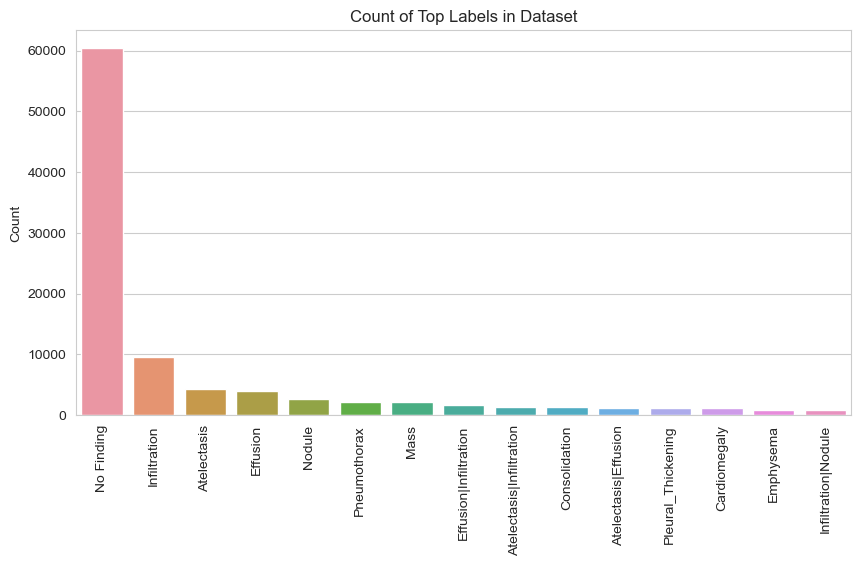

In [147]:
import seaborn as sns
multiclass_counts = all_xray_df['Finding Labels'].value_counts()
multilabel_counts = multiclass_counts[:15]

plot_bar(multilabel_counts.index, multilabel_counts.values, "Count of Top Labels in Dataset")

In [148]:
multilabel_counts.index = multilabel_counts.index.map(lambda x: x.replace('No Finding', ''))

In [149]:
from bitarray import bitarray

# Define the class labels in a sorted set
all_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
unique_labels = all_labels.copy()

d = {label: ix for ix, label in enumerate(all_labels)}

# Column "Finding Labels" contains multiple label names separated by "|". "No Finding" means no disease.
# Define a function to convert "Finding Labels" to one-hot encoded in one hot encoded vector stored in "Disease Vector". "No Finding" is encoded as all zeros.
def convert_labels_to_vector(labels):
    # split labels by "|"
    labels = labels.split("|")
    # create a bitarray full of False with length of unique_diseases
    vector = bitarray('0'*14)
    # if "No Finding" in labels, return vector
    if "No Finding" in labels:
        return vector
    # for each label in labels, set the corresponding index in vector to 1
    for label in labels:
        vector[d[label]] = 1

    return vector

# Apply convert_labels_to_vector to "Finding Labels" column and store in "Disease Vector" column

In [150]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [151]:
list(enumerate(all_xray_df.columns))

[(0, 'Image Index'),
 (1, 'Finding Labels'),
 (2, 'Follow-up #'),
 (3, 'Patient ID'),
 (4, 'Patient Age'),
 (5, 'Patient Gender'),
 (6, 'View Position'),
 (7, 'path'),
 (8, 'Atelectasis'),
 (9, 'Cardiomegaly'),
 (10, 'Consolidation'),
 (11, 'Edema'),
 (12, 'Effusion'),
 (13, 'Emphysema'),
 (14, 'Fibrosis'),
 (15, 'Hernia'),
 (16, 'Infiltration'),
 (17, 'Mass'),
 (18, 'Nodule'),
 (19, 'Pleural_Thickening'),
 (20, 'Pneumonia'),
 (21, 'Pneumothorax')]

In [161]:
columns = all_xray_df.columns[8:22]
all_xray_df = all_xray_df[all_xray_df[columns].values.sum(axis=1) == 1]

all_xray_df['disease_vec'] = all_xray_df[columns].apply(lambda x: tuple(x.values), axis=1)

In [162]:
type(all_xray_df.iloc[0]['disease_vec'])

tuple

In [163]:
weights = 1 / all_xray_df['disease_vec'].value_counts()
weights = weights / weights.sum()
weights = dict(weights)

In [164]:
weights

{(0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): 0.005050471022125331,
 (1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): 0.011439346820458015,
 (0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): 0.012191364563395837,
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0): 0.017825082014133284,
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0): 0.021976684980961957,
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0): 0.022541770382529473,
 (0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0): 0.03680675331925995,
 (0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0): 0.04282135599309995,
 (0.0,
  1.0,
  0.0,
  0.0,
  0.0,

In [165]:
all_xray_df['weights'] = all_xray_df['disease_vec'].map(lambda x: weights[x])

In [167]:
all_xray_df = all_xray_df.sample(40000, weights='weights', replace=True)

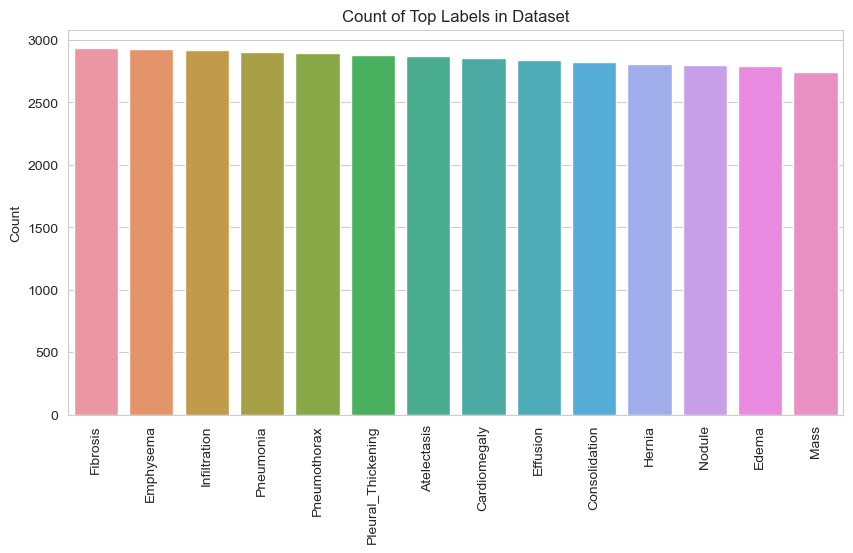

In [168]:
multilabel_counts = all_xray_df['Finding Labels'].value_counts()[:15]

plot_bar(multilabel_counts.index, multilabel_counts.values, "Count of Top Labels in Dataset")

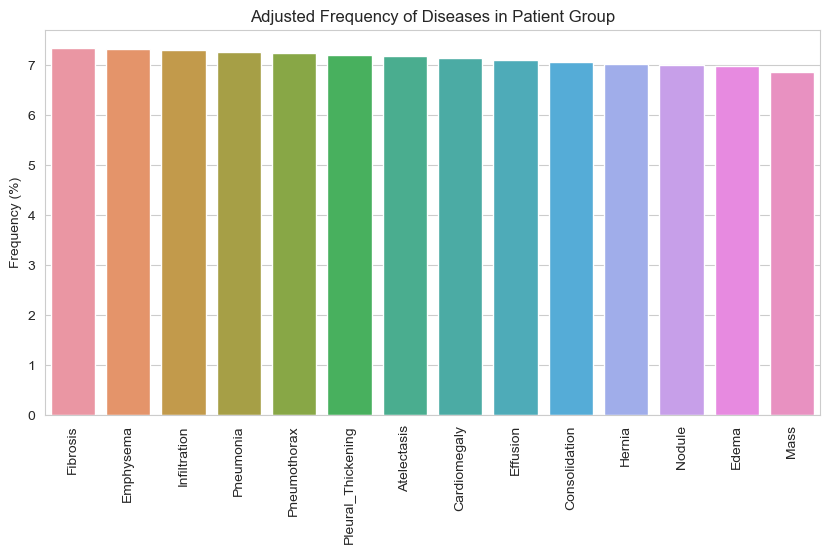

In [169]:
multilabel_counts = 100 * np.mean(all_xray_df[all_labels].values, axis=0)
l_value_counts = sorted(zip(all_labels, multilabel_counts), key=lambda x: x[1], reverse=True)

plot_bar([v[0] for v in l_value_counts], [v[1] for v in l_value_counts], "Adjusted Frequency of Diseases in Patient Group", y_label="Frequency (%)")

In [170]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                      test_size = 0.25,
                                      random_state = 2018,
                                      stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'validation', valid_df.shape[0])

# select 'disease_vec' from row 0
len(train_df.iloc[0]['disease_vec'])


train 30000 validation 10000


14

In [171]:
path = os.getcwd()

In [172]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
BATCH_SIZE = 30
VALID_BATCH_SIZE = 250
TEST_BATCH_SIZE = 1000
STEPS_PER_EPOCH = 100
COLOR_CHANNELS = 1

# this is the augmentation configuration we will use for training
# convert to float32, rescale to [0,1] and normalize to mean 0 and std 1

core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [173]:
import tensorflow as tf
# define cmap that converts color_mode to channel count
clr_mode = {1: 'grayscale', 3: 'rgb'}

# def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, target_size=(128, 128), color_mode='rgb', batch_size=32, shuffle=False, seed=None):
def dataset_from_dataframe(img_data_gen, in_df, path_col, y_col, target_size=IMG_SIZE, color_channels=COLOR_CHANNELS, batch_size=BATCH_SIZE, seed=None):
    df_gen = img_data_gen.flow_from_dataframe(
        in_df, directory=os.getcwd(),
        x_col=path_col,
        y_col=y_col,
        class_mode='raw',
        batch_size=batch_size,
        target_size=target_size,
        color_mode=clr_mode[color_channels],
        shuffle=True,
        repeat=True,
        seed=seed
    )

    # Convert to a tf.data.Dataset object
    def data_generator():
        while True:
            x, y = next(df_gen)
            yield x, np.vstack(y)


    train_ds = tf.data.Dataset.from_generator(data_generator,
                                              output_signature=(
                                                    tf.TensorSpec(shape=(batch_size, *target_size, color_channels), dtype=tf.float32),
                                                    tf.TensorSpec(shape=(batch_size, len(all_labels)), dtype=tf.float32)))

    return train_ds


In [174]:
train_ds = dataset_from_dataframe(core_idg, train_df,
                                  path_col = 'path',
                                  y_col = 'disease_vec',
                                  target_size = IMG_SIZE,
                                  color_channels=COLOR_CHANNELS,
                                  batch_size = BATCH_SIZE)
valid_ds = dataset_from_dataframe(core_idg, valid_df,
                                  path_col = 'path',
                                  y_col = 'disease_vec',
                                  target_size = IMG_SIZE,
                                  color_channels=COLOR_CHANNELS,
                                  batch_size = VALID_BATCH_SIZE) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_ds = dataset_from_dataframe(core_idg, valid_df,
                                 path_col = 'path',
                                 y_col = 'disease_vec',
                                 target_size = IMG_SIZE,
                                 color_channels=COLOR_CHANNELS,
                                 batch_size = TEST_BATCH_SIZE) # one big batch

test_X, test_y = next(iter(test_ds))

Found 30000 validated image filenames.
Metal device set to: Apple M1 Pro
Found 10000 validated image filenames.
Found 10000 validated image filenames.


2023-02-19 20:56:39.785838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-19 20:56:39.785858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-19 20:56:39.955419: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [175]:
test_X.shape, test_y.shape, STEPS_PER_EPOCH

(TensorShape([1000, 128, 128, 1]), TensorShape([1000, 14]), 100)

In [176]:
## Creating model
import tensorflow_hub as hub

from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, COLOR_CHANNELS),
                                 include_top = False, weights = None)
# model_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
# resnet = hub.KerasLayer(model_url, input_shape=(*IMG_SIZE, COLOR_CHANNELS), trainable=False)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
# multi_disease_model.add(resnet)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512, activation = 'relu'))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss = 'binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                7

In [177]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, verbose = 1,
                        min_delta = 1e-4, min_lr = 1e-6, mode = 'min', cooldown=1)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [rlr, checkpoint, early]

In [178]:
multi_disease_model.fit(train_ds,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data = (test_X, test_y),
                        epochs = 1,
                        callbacks = callbacks_list)

2023-02-19 20:57:11.378016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.2901 - binary_accuracy: 0.9219 - mae: 0.1398

2023-02-19 20:57:41.583929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.31136, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 32s 301ms/step - loss: 0.2901 - binary_accuracy: 0.9219 - mae: 0.1398 - val_loss: 0.3114 - val_binary_accuracy: 0.9286 - val_mae: 0.2285 - lr: 0.0010


In [179]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_y,axis=0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 7.00%
Cardiomegaly: 7.40%
Consolidation: 7.90%
Edema: 7.10%
Effusion: 7.10%
Emphysema: 5.90%
Fibrosis: 8.60%
Hernia: 6.70%
Infiltration: 7.70%
Mass: 7.10%
Nodule: 7.00%
Pleural_Thickening: 6.00%
Pneumonia: 7.90%
Pneumothorax: 6.60%


In [180]:
pred_y = multi_disease_model.predict(test_X, batch_size = 1024, verbose = True)

2023-02-19 20:57:50.649492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 802ms/step


In [181]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# get np array of test_y
test_Y = test_y.numpy()

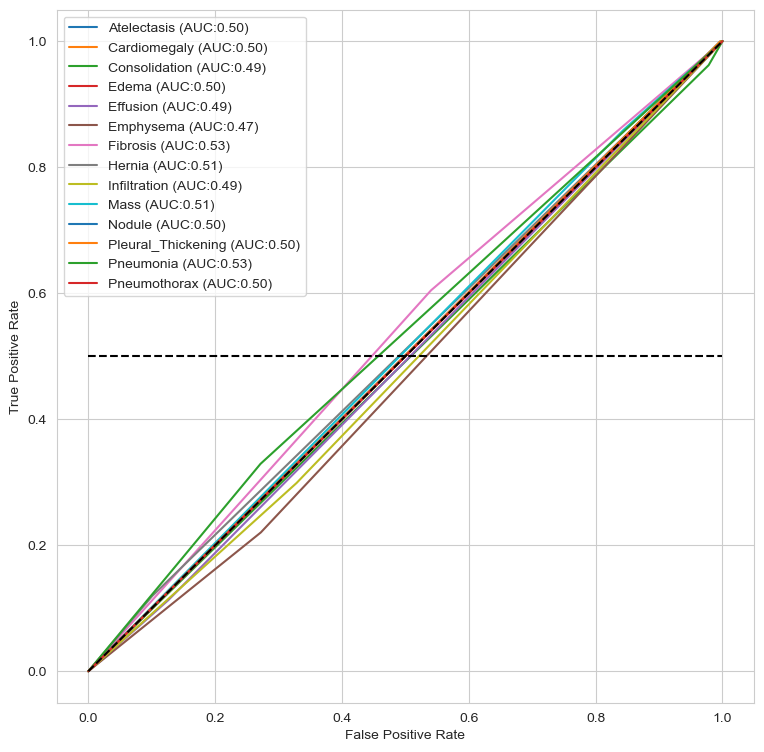

In [182]:
def plot_roc_curve(test_Y, pred_y, all_labels):
    from sklearn.metrics import roc_curve, auc
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_y[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    # add threshold line at y=0.5
    c_ax.plot([0, 1], [0.5, 0.5], linestyle='--', color='black')
    # add black line y=x
    c_ax.plot([0, 1], [0, 1], linestyle='--', color='black')
    fig.savefig('barely_trained_net.png')

plot_roc_curve(test_Y, pred_y, all_labels)

# Continued training

In [183]:
multi_disease_model.fit(train_ds,
                                  steps_per_epoch = STEPS_PER_EPOCH,
                                  validation_data =  (test_X, test_y),
                                  epochs = 10,
                                  callbacks = [rlr, checkpoint])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.2634 - binary_accuracy: 0.9284 - mae: 0.1339
Epoch 1: val_loss improved from 0.31136 to 0.26656, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 30s 300ms/step - loss: 0.2634 - binary_accuracy: 0.9284 - mae: 0.1339 - val_loss: 0.2666 - val_binary_accuracy: 0.9286 - val_mae: 0.1231 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2582 - binary_accuracy: 0.9283 - mae: 0.1324
Epoch 2: val_loss did not improve from 0.26656
100/100 [==============================] - 29s 296ms/step - loss: 0.2582 - binary_accuracy: 0.9283 - mae: 0.1324 - val_loss: 0.2858 - val_binary_accuracy: 0.9286 - val_mae: 0.1067 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2552 - binary_accuracy: 0.9283 - mae: 0.1318
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 3: val_loss did not improve from 0.

32/32 [==============================] - 1s 20ms/step


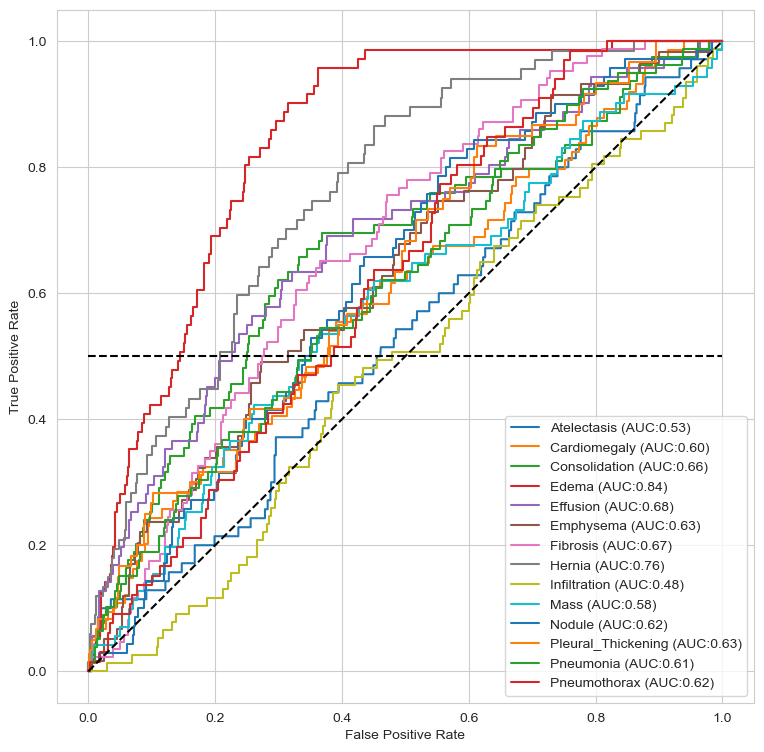

In [184]:
pred_y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)
test_Y = test_y.numpy()

plot_roc_curve(test_Y, pred_y, all_labels)

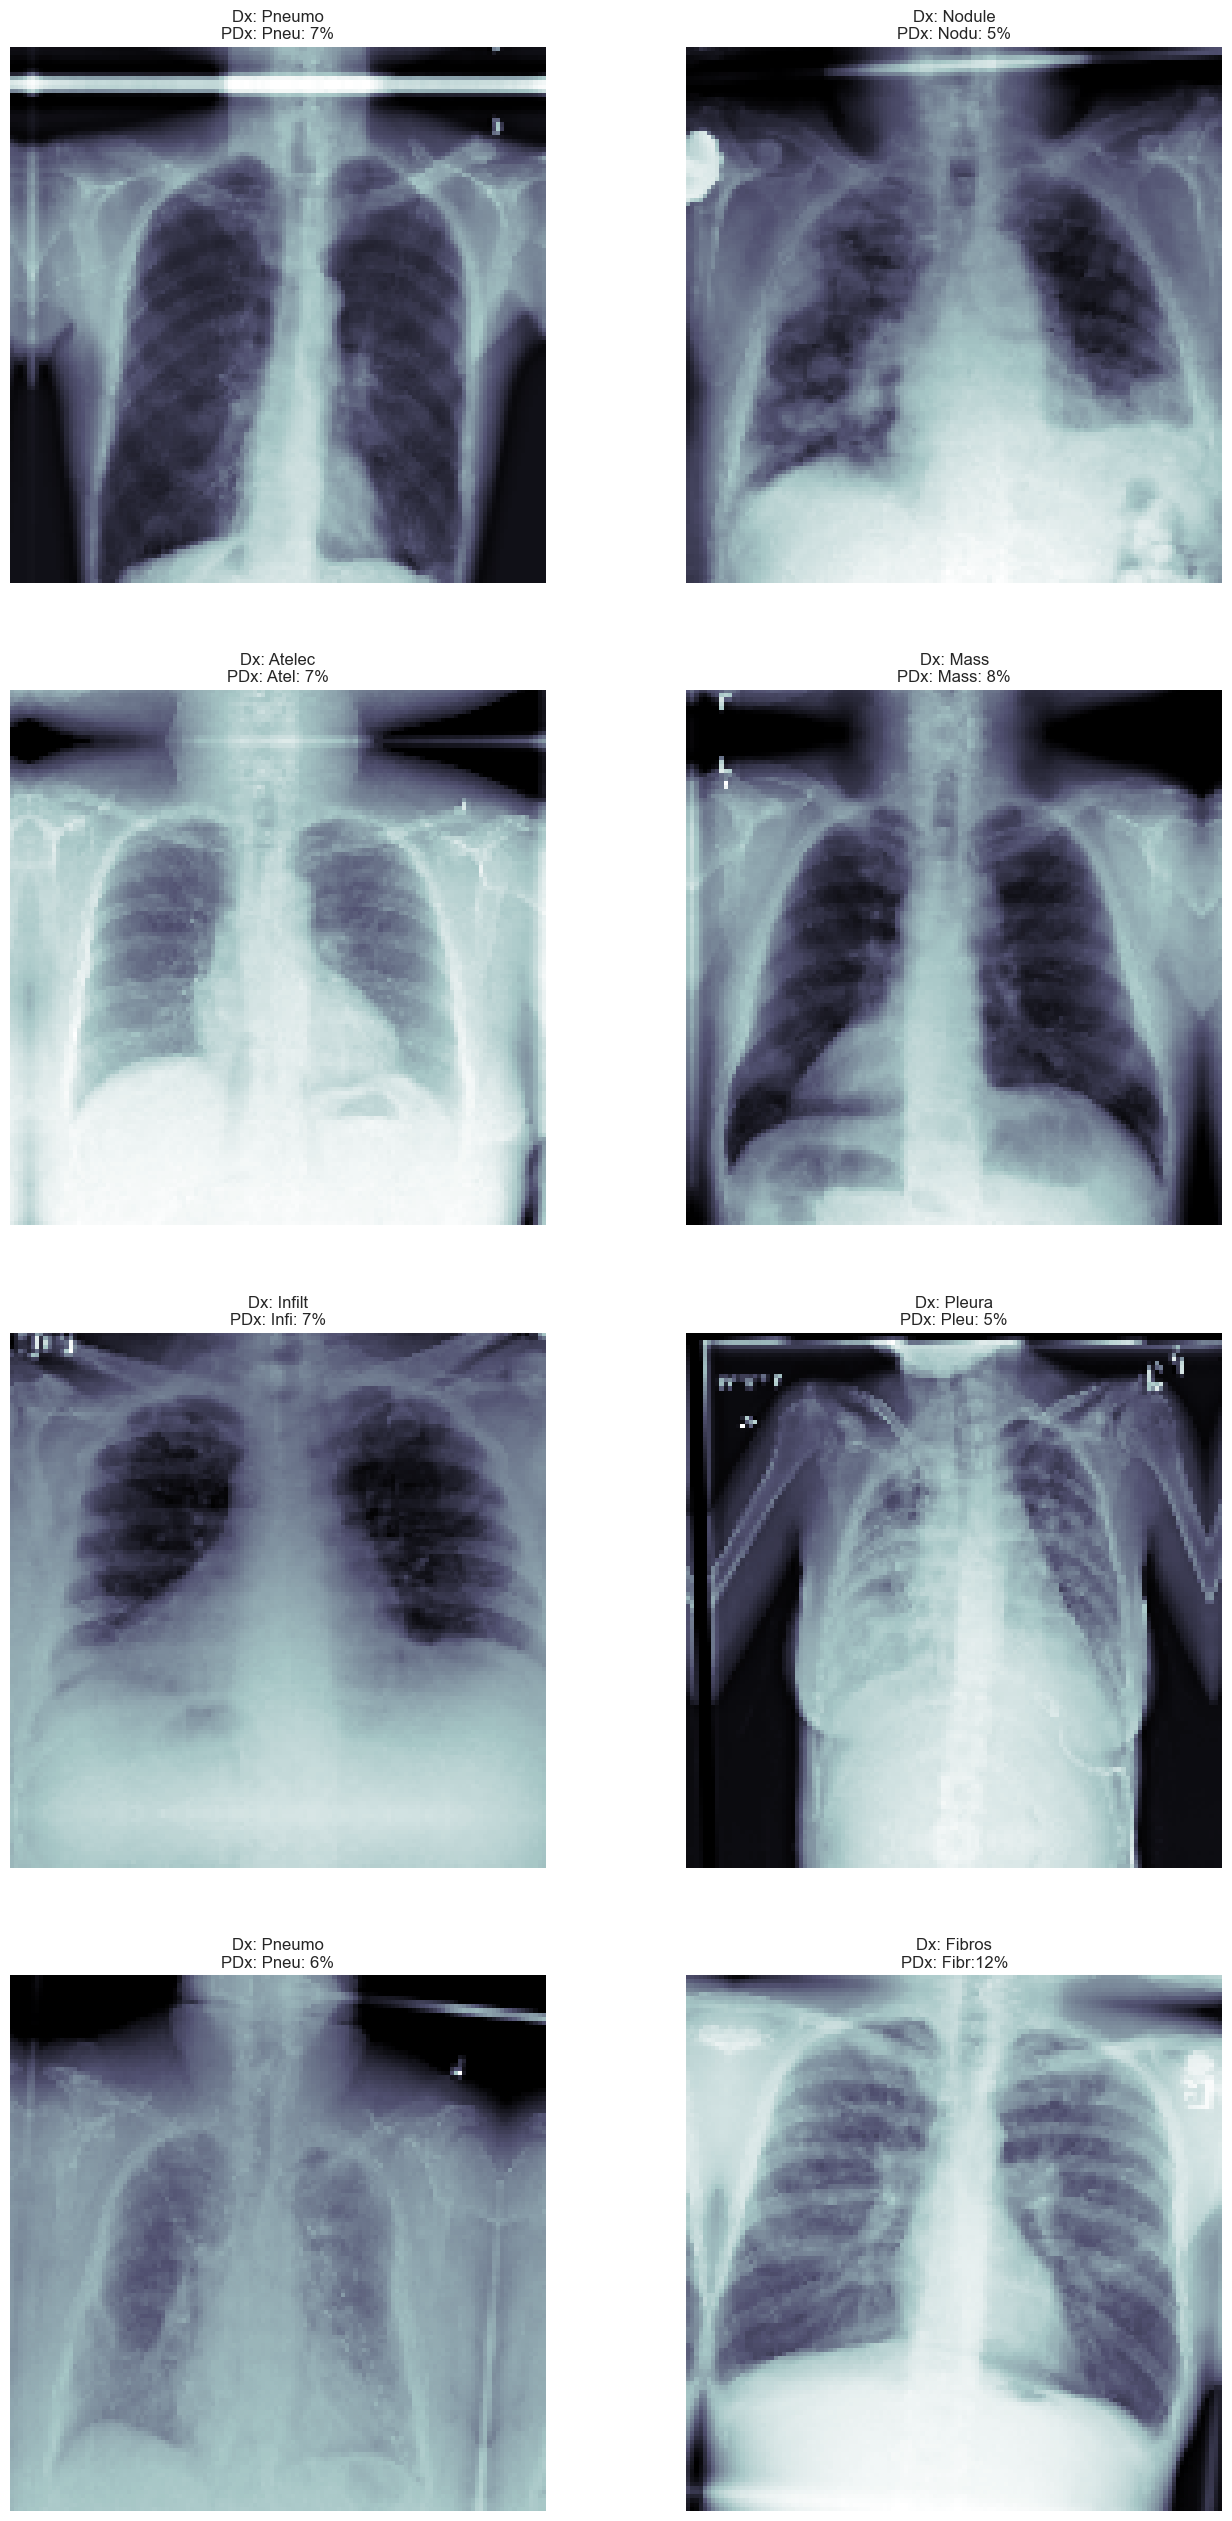

In [188]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                        test_Y[idx])
                if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                                                test_Y[idx], pred_y[idx])
                if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [ ]:
from sklearn.metrics import accuracy_score

sum_y_pred = np.sum(pred_y>0.25, 1)
sum_y_test = np.sum(test_Y, 1)

# plot confusion matrix with sns.heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix(sum_y_test, sum_y_pred), annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(sum_y_test, sum_y_pred))
plt.title(all_sample_title, size = 15);
fig.savefig('trained_img_confusion_matrix.png')


